# Jupyter Notebook to handle the preprocessing and testing of datasets before training

## 1. Brain Tumor MRI Dataset

https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

### 1.1 - Test to check leakage between train and test sets

In [5]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet50(pretrained=True)
feature_extractor = nn.Sequential(*list(resnet.children())[:-1]).to(device)
feature_extractor.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [6]:
def list_images(folder):
    exts = [".jpg", ".png", ".jpeg", ".bmp"]
    files = []
    for root, dirs, names in os.walk(folder):
        for n in names:
            if any(n.lower().endswith(e) for e in exts):
                files.append(os.path.join(root, n))
    return files

train_root = "./Training"
test_root  = "./Testing"

classes = os.listdir(train_root)

train_imgs = {cls: list_images(os.path.join(train_root, cls)) for cls in classes}
test_imgs  = {cls: list_images(os.path.join(test_root, cls)) for cls in classes}


In [7]:
def extract_feature(path):
    img = Image.open(path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = feature_extractor(x)
    return feat.flatten()

train_features = {}
for cls in classes:
    train_features[cls] = []
    for path in train_imgs[cls]:
        train_features[cls].append(extract_feature(path))

threshold = 0.95
class_counts = {cls: [] for cls in classes}

for cls in classes:
    print("\n", cls)
    for test_path in test_imgs[cls]:
        test_feat = extract_feature(test_path)
        count = 0
        for train_feat in train_features[cls]:
            score = torch.nn.functional.cosine_similarity(test_feat, train_feat, dim=0).item()
            if score >= threshold:
                count += 1
        class_counts[cls].append(count)
        print(test_path, "->", count)



 glioma
./Testing\glioma\Te-glTr_0000.jpg -> 1
./Testing\glioma\Te-glTr_0001.jpg -> 1
./Testing\glioma\Te-glTr_0002.jpg -> 3
./Testing\glioma\Te-glTr_0003.jpg -> 0
./Testing\glioma\Te-glTr_0004.jpg -> 1
./Testing\glioma\Te-glTr_0005.jpg -> 2
./Testing\glioma\Te-glTr_0006.jpg -> 0
./Testing\glioma\Te-glTr_0007.jpg -> 1
./Testing\glioma\Te-glTr_0008.jpg -> 1
./Testing\glioma\Te-glTr_0009.jpg -> 3
./Testing\glioma\Te-gl_0010.jpg -> 0
./Testing\glioma\Te-gl_0011.jpg -> 1
./Testing\glioma\Te-gl_0012.jpg -> 1
./Testing\glioma\Te-gl_0013.jpg -> 0
./Testing\glioma\Te-gl_0014.jpg -> 6
./Testing\glioma\Te-gl_0015.jpg -> 1
./Testing\glioma\Te-gl_0016.jpg -> 6
./Testing\glioma\Te-gl_0017.jpg -> 1
./Testing\glioma\Te-gl_0018.jpg -> 4
./Testing\glioma\Te-gl_0019.jpg -> 3
./Testing\glioma\Te-gl_0020.jpg -> 0
./Testing\glioma\Te-gl_0021.jpg -> 0
./Testing\glioma\Te-gl_0022.jpg -> 2
./Testing\glioma\Te-gl_0023.jpg -> 0
./Testing\glioma\Te-gl_0024.jpg -> 0
./Testing\glioma\Te-gl_0025.jpg -> 8
./Testing

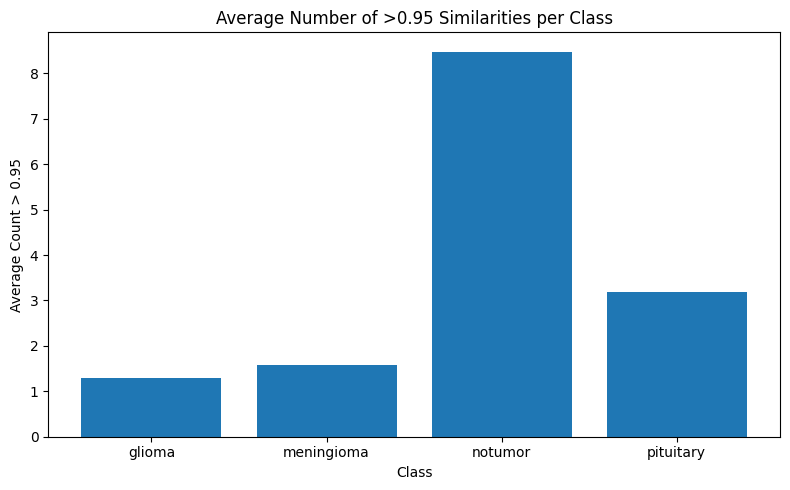

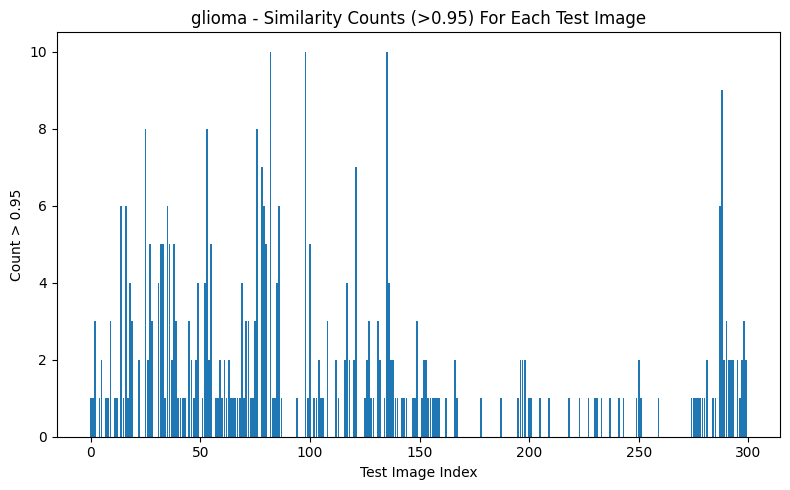

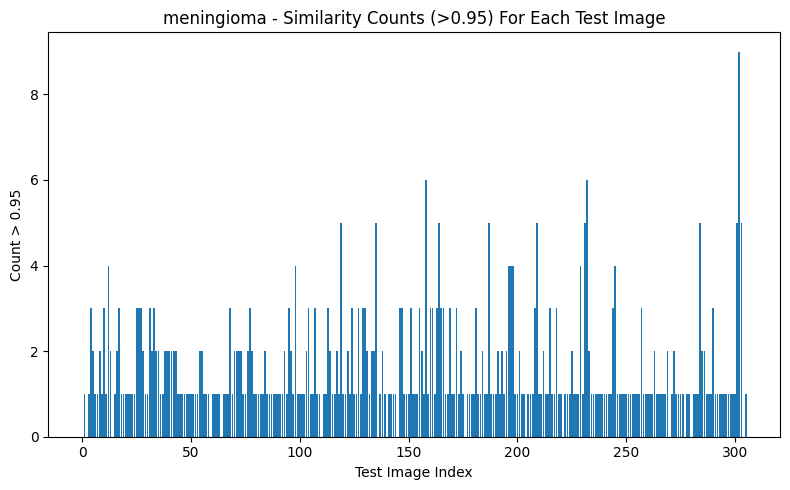

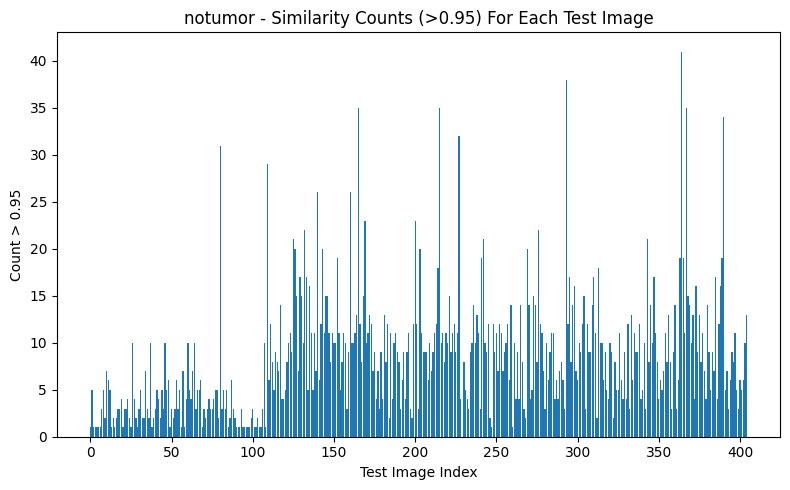

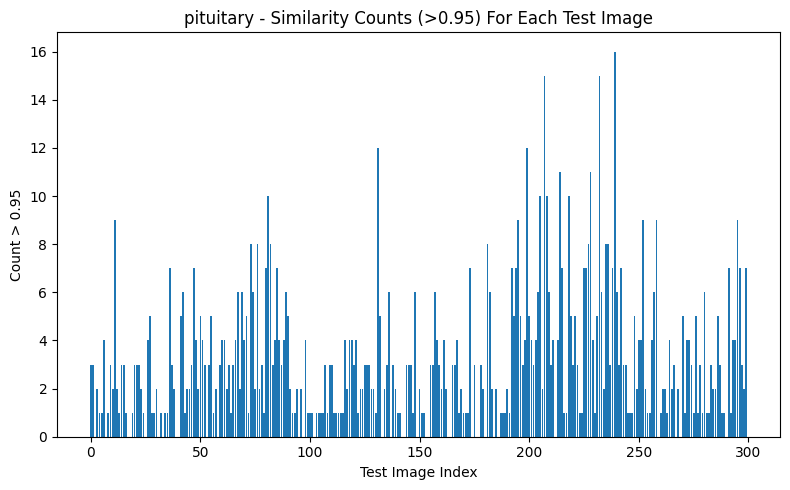

In [8]:
avg_counts = {
    cls: (sum(vals)/len(vals) if len(vals) > 0 else 0)
    for cls, vals in class_counts.items()
}

plt.figure(figsize=(8,5))
plt.bar(avg_counts.keys(), avg_counts.values())
plt.title("Average Number of >0.95 Similarities per Class")
plt.xlabel("Class")
plt.ylabel("Average Count > 0.95")
plt.tight_layout()
plt.show()
for cls in classes:
    plt.figure(figsize=(8,5))
    plt.bar(range(len(class_counts[cls])), class_counts[cls])
    plt.title(f"{cls} - Similarity Counts (>0.95) For Each Test Image")
    plt.xlabel("Test Image Index")
    plt.ylabel("Count > 0.95")
    plt.tight_layout()
    plt.show()



## 2. Brain Tumor Segmentation(BraTS2020)

https://www.kaggle.com/datasets/awsaf49/brats2020-training-data

### 2.1 - Understanding the Data

In [ ]:
import os, h5py
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from config import BRATS_DATASET_PATH

brats_dir = Path(BRATS_DATASET_PATH) / "content" / "data"

Plot a sample slice from the dataset

['image', 'mask']
(240, 240, 4) (240, 240, 3)


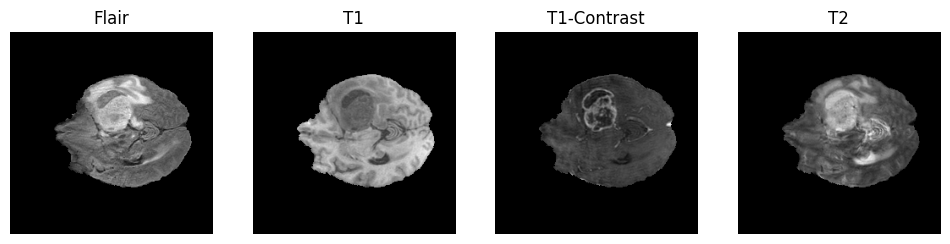

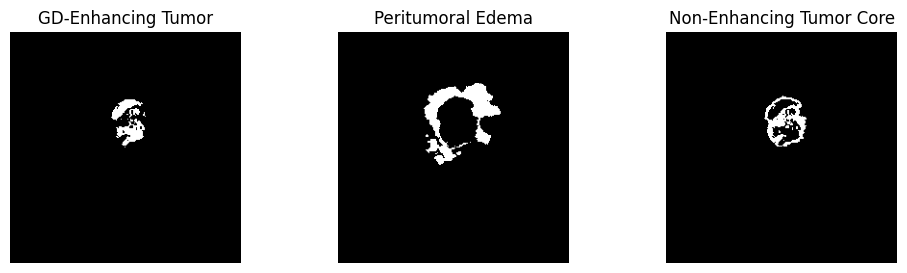

In [2]:
sample_dir = brats_dir / "volume_1_slice_60.h5"

modalities = ["Flair", "T1", "T1-Contrast", "T2"]
mask_types = ["GD-Enhancing Tumor", "Peritumoral Edema", "Non-Enhancing Tumor Core"]

with h5py.File(sample_dir, "r") as f:
    print(list(f.keys()))
    img = f["image"][:]
    mask = f["mask"][:] 
    print(img.shape, mask.shape)

    #Plot the images and masks
    plt.figure(figsize=(12, 3))
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.imshow(img[:, :, i], cmap="gray")
        plt.title(modalities[i])
        plt.axis("off")

    plt.show()

    plt.figure(figsize=(12, 3))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(mask[:, :, i], cmap="gray")
        plt.title(mask_types[i])
        plt.axis("off")

    plt.show()


Plot all the slices of a sample to represent the volume

Found 155 volume files.


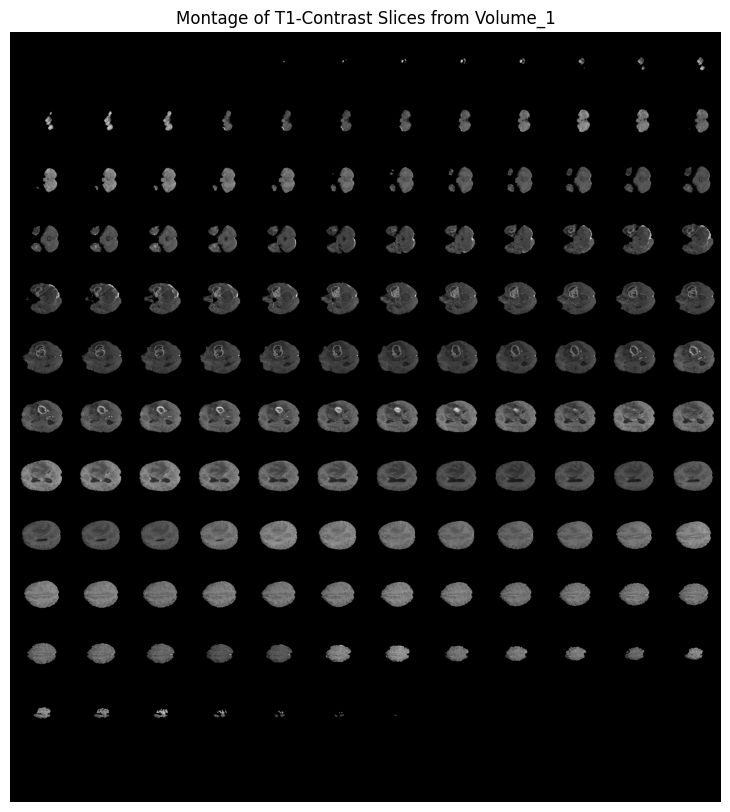

In [3]:
def make_montage(img_set):
    # img_set = (D, H, W)
    D, H, W = img_set.shape
    n_rows = int(np.ceil(np.sqrt(D)))
    n_cols = int(np.ceil(D / n_rows))
    montage = np.zeros((n_rows * H, n_cols * W))
    for i in range(D):
        row = i // n_cols
        col = i % n_cols
        montage[row*H:(row+1)*H, col*W:(col+1)*W] = img_set[i, :, :]
    return montage

def normalize_slice(slice):
    p_low, p_high = np.min(slice), np.max(slice)
    if p_high - p_low <= 0:
        return np.zeros_like(slice)
    slice = (slice - p_low) / (p_high - p_low)
    return slice.astype(np.float32)

# collect HDF5 files in brats_dir whose names start with "volume_1"
volume_files = [p for p in brats_dir.iterdir() if p.is_file() and p.name.startswith("volume_1_") and p.suffix.lower() in (".h5", ".hdf5")]
volume_files = sorted(volume_files, key=lambda x: int(x.name.split("_")[-1].split(".")[0]))  # sort by the index of the slice

print(f"Found {len(volume_files)} volume files.")

img_sets = []
for vf in volume_files:
    with h5py.File(vf, "r") as f:
        img = f["image"][:][:, :, 2]
        img_sets.append(normalize_slice(img))

np_img_sets = np.array(img_sets)  # shape: (N, H, W)
montage = make_montage(np_img_sets)

plt.figure(figsize=(10, 10))
plt.imshow(montage, cmap="gray")
plt.title("Montage of T1-Contrast Slices from Volume_1")
plt.axis("off")
plt.show()

### 2.2 - Processing the slices to be used

Selecting slices with maximum enhancing tumor area (ET) for each volume.

Using "BraTS20 Training Metadata.csv" file provided inside the dataset (label0_pxl_cnt column (ET))

In [ ]:
import os, csv
from pathlib import Path
from config import BRATS_DATASET_PATH

#CSV is supposed to be in the parent directory of BRATS_DATASET_PATH
csv_path = Path(BRATS_DATASET_PATH).parent / "BraTS20 Training Metadata.csv"

In [ ]:
#Read the CSV and find the slice with the biggest enhancing tumor area for each volume
with open(csv_path, "r") as f:
    reader = csv.DictReader(f)
    volume_dict = {}
    
    for row in reader:
        volume_slice = row["slice_path"].split("/")[-1]
        volume_index, slice_index = map(int, volume_slice.replace("volume_","").replace(".h5","").split("_slice_")) 
        enhancing_tumor_area = int(row["label0_pxl_cnt"])
        if enhancing_tumor_area < 100:  # skip slices with negligible enhancing tumor area
            continue
        if volume_index not in volume_dict:
            volume_dict[volume_index] = (slice_index, enhancing_tumor_area)
        else:
            if enhancing_tumor_area > volume_dict[volume_index][1]:
                volume_dict[volume_index] = (slice_index, enhancing_tumor_area)

print(f"Total of slices selected: {len(volume_dict)}")
print(f"Biggest enhancing tumor slice for volume 1: {volume_dict[1][0]} with area {volume_dict[1][1]} pixels")
        

Total of slices selected: 326
Biggest enhancing tumor slice for volume 1: 61 with area 768 pixels


Minimum area: 100, Maximum area: 4214, Average area: 907.98


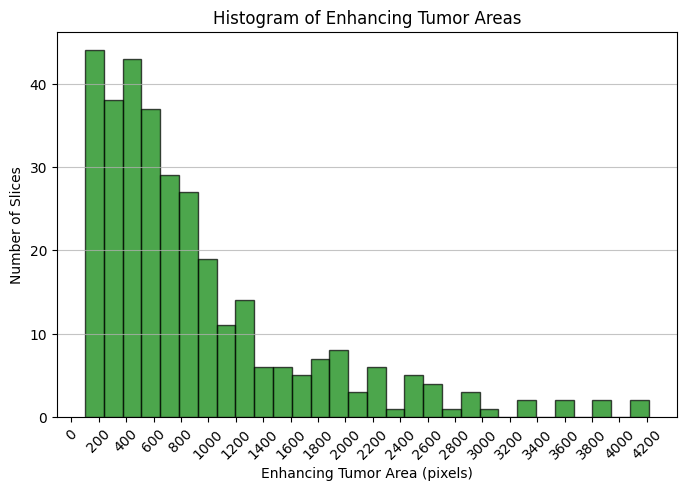

In [ ]:
#Make histogram of enhancing tumor areas
areas = [area for slice_index, area in volume_dict.values()]
print(f"Minimum area: {min(areas)}, Maximum area: {max(areas)}, Average area: {sum(areas)/len(areas):.2f}")
plt.figure(figsize=(8,5))
plt.hist(areas, bins=30, color='green', alpha=0.7, edgecolor='black')
plt.xticks(range(0, max(areas)+100, 200), rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.title("Histogram of Enhancing Tumor Areas")
plt.xlabel("Enhancing Tumor Area (pixels)")
plt.ylabel("Number of Slices")
plt.show()


In [128]:
#Save the selected slices relative path to a csv file
output_csv_path = "BraTS/BraTS_selected_slices.csv"
if not os.path.exists("BraTS"):
    os.makedirs("BraTS")
    
with open(output_csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["slice_relative_path"])
    for volume_index, (slice_index, area) in volume_dict.items():
        slice_path = f"volume_{volume_index}_slice_{slice_index}.h5"
        writer.writerow([slice_path])

### 2.3 - Plot Samples with Masks From the Choosen Slices

In [129]:
import os, h5py, csv, random
import numpy as np
from pathlib import Path
from config import BRATS_DATASET_PATH

#CSV is supposed to be in the parent directory of BRATS_DATASET_PATH
sample_csv_path = "BraTS/BraTS_selected_slices.csv"
brats_dir = Path(BRATS_DATASET_PATH) / "content" / "data"

Loaded volume_150_slice_48.h5 with image shape (240, 240) and mask shape (240, 240, 3)
Loaded volume_335_slice_76.h5 with image shape (240, 240) and mask shape (240, 240, 3)
Loaded volume_175_slice_70.h5 with image shape (240, 240) and mask shape (240, 240, 3)
Loaded volume_265_slice_81.h5 with image shape (240, 240) and mask shape (240, 240, 3)
Loaded volume_84_slice_57.h5 with image shape (240, 240) and mask shape (240, 240, 3)
Loaded volume_73_slice_81.h5 with image shape (240, 240) and mask shape (240, 240, 3)
Loaded volume_147_slice_83.h5 with image shape (240, 240) and mask shape (240, 240, 3)
Loaded volume_302_slice_62.h5 with image shape (240, 240) and mask shape (240, 240, 3)


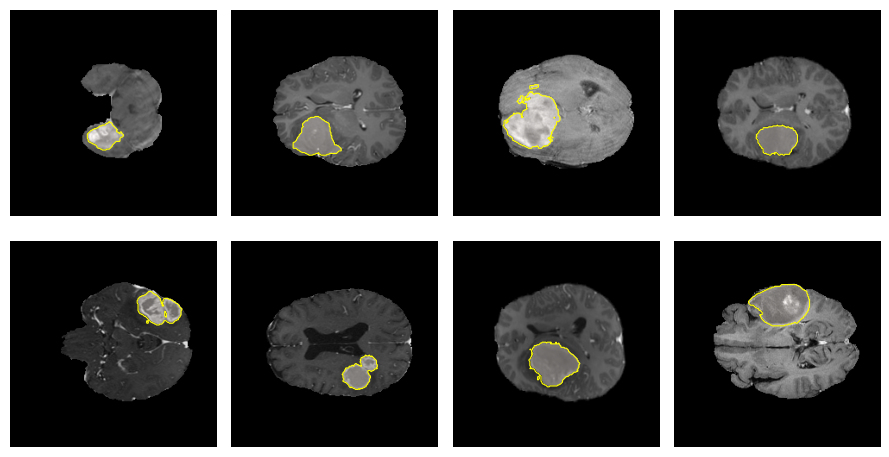

In [ ]:
num_samples = 8 # number of samples to display (multiple of 4 preferred)
with open(sample_csv_path, "r") as f:
    lines = f.readlines()
    fig, axes = plt.subplots(num_samples // 4, 4, figsize=(9, 5))
    for i, line in enumerate(random.sample(lines[1:], (num_samples // 4) * 4)):
        slice_relative_path = line.strip()
        slice_path = brats_dir / slice_relative_path
        with h5py.File(slice_path, "r") as f:
            img = f["image"][:][:, : ,2]
            mask = f["mask"][:]
            print(f"Loaded {slice_relative_path} with image shape {img.shape} and mask shape {mask.shape}")

            #Tumor area = sum of GD-Enhancing Tumor pixels and Non-Enhancing Tumor Core pixels
            tumor_area = (mask[:, :, 0] > 0) + (mask[:, :, 2] > 0)
            
            axes[i // 4][i % 4].imshow(img, cmap="gray")
            overlay = np.ma.masked_where(tumor_area == 0, tumor_area)
            axes[i // 4][i % 4].imshow(overlay, cmap="Reds", alpha=0.35)
            axes[i // 4][i % 4].contour(tumor_area, levels=[0.5], colors="yellow", linewidths=0.8)
            axes[i // 4][i % 4].axis("off")
    plt.tight_layout()
    plt.show()